**Pyspark Data Analysis of Boston Hounsing**

In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=b229eaf8dbb8f6d7629c37183ae148acb28bc23ad9bc9e12c9da50aff7e3de06
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving BostonHousing.csv to BostonHousing.csv


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when
from pyspark.sql.types import DoubleType

# Initialize Spark session
spark = SparkSession.builder.master("local[*]").appName("BostonHousing").getOrCreate()

In [ ]:
# Load the dataset
df = spark.read.csv('BostonHousing.csv', header=True, inferSchema=True)

# Show the schema to understand the data types
df.printSchema()

# Display the first few rows of the dataframe
df.show(5)

root
 |-- crim: double (nullable = true)
 |-- zn: double (nullable = true)
 |-- indus: double (nullable = true)
 |-- chas: integer (nullable = true)
 |-- nox: double (nullable = true)
 |-- rm: double (nullable = true)
 |-- age: double (nullable = true)
 |-- dis: double (nullable = true)
 |-- rad: integer (nullable = true)
 |-- tax: integer (nullable = true)
 |-- ptratio: double (nullable = true)
 |-- b: double (nullable = true)
 |-- lstat: double (nullable = true)
 |-- medv: double (nullable = true)

+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+
|   crim|  zn|indus|chas|  nox|   rm| age|   dis|rad|tax|ptratio|     b|lstat|medv|
+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+
|0.00632|18.0| 2.31|   0|0.538|6.575|65.2|  4.09|  1|296|   15.3| 396.9| 4.98|24.0|
|0.02731| 0.0| 7.07|   0|0.469|6.421|78.9|4.9671|  2|242|   17.8| 396.9| 9.14|21.6|
|0.02729| 0.0| 7.07|   0|0.469|7.185|61.1|4.9671|  2|242|   17.8|392.83| 4

In [ ]:
# Check for missing values
df.select([col(c).isNull().alias(c) for c in df.columns]).show()

# Assuming 'None' indicates missing values, deal na
df = df.na.drop()

+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-------+-----+-----+-----+
| crim|   zn|indus| chas|  nox|   rm|  age|  dis|  rad|  tax|ptratio|    b|lstat| medv|
+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-------+-----+-----+-----+
|false|false|false|false|false|false|false|false|false|false|  false|false|false|false|
|false|false|false|false|false|false|false|false|false|false|  false|false|false|false|
|false|false|false|false|false|false|false|false|false|false|  false|false|false|false|
|false|false|false|false|false|false|false|false|false|false|  false|false|false|false|
|false|false|false|false|false|false|false|false|false|false|  false|false|false|false|
|false|false|false|false|false|false|false|false|false|false|  false|false|false|false|
|false|false|false|false|false|false|false|false|false|false|  false|false|false|false|
|false|false|false|false|false|false|false|false|false|false|  false|false|false|false|
|false|false|false|false|false|f

In [ ]:
!pip install matplotlib seaborn

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convert the PySpark DataFrame to a Pandas DataFrame for easier plotting
df_pd = df.toPandas()

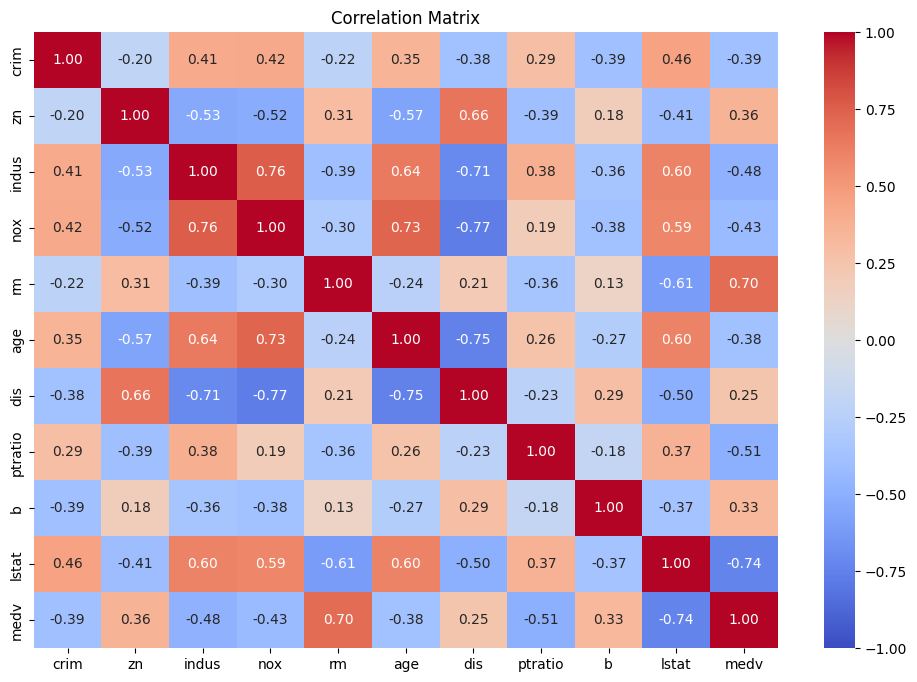

In [ ]:
# Calculate the correlation matrix
numeric_df_pd = df_pd.select_dtypes(include=['float64', 'int64'])
corr_matrix = numeric_df_pd.corr()

# Plot the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

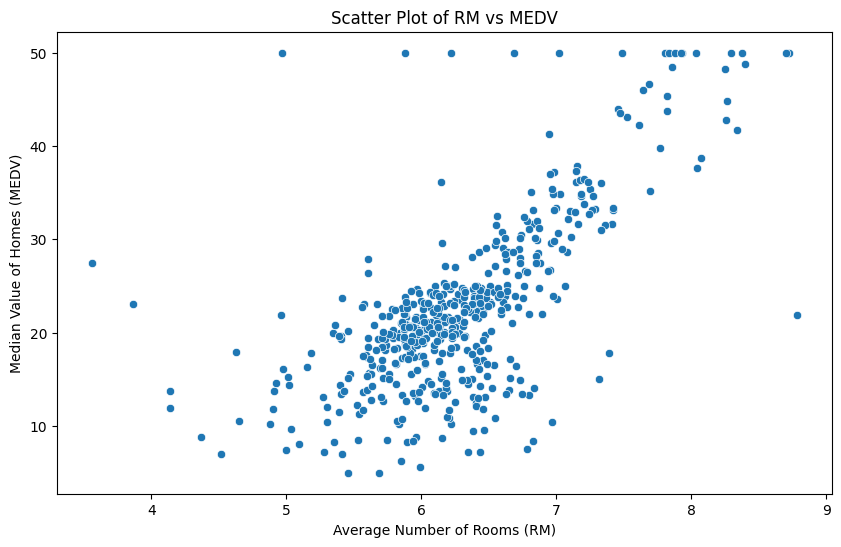

In [ ]:
# Scatter plot of RM vs MEDV

plt.figure(figsize=(10, 6))
sns.scatterplot(x='rm', y='medv', data=df_pd)
plt.title('Scatter Plot of RM vs MEDV')
plt.xlabel('Average Number of Rooms (RM)')
plt.ylabel('Median Value of Homes (MEDV)')
plt.show()

In [ ]:
from pyspark.sql.functions import mean, stddev, count, expr

# Calculate the statistics
statistics_general = df.agg(
    count("MEDV").alias("count"),
    mean("MEDV").alias("mean_MEDV"),
    expr('percentile_approx(MEDV, 0.5)').alias('median_MEDV'),
    stddev("MEDV").alias("stddev_MEDV")
)

# Display the results
statistics_general.show()

+-----+------------------+-----------+-----------------+
|count|         mean_MEDV|median_MEDV|      stddev_MEDV|
+-----+------------------+-----------+-----------------+
|  506|22.532806324110698|       21.2|9.197104087379815|
+-----+------------------+-----------+-----------------+



In [ ]:
# Define bins for the 'RM' attribute
bins = [0, 4, 5, 6, 7, 8, 10]
labels = ["<4", "4-5", "5-6", "6-7", "7-8", "8-10"]

# Use a case-when construct to create the bins
df = df.withColumn("RM_bin", when((col("RM") < 4), "<4")
                   .when((col("RM") >= 4) & (col("RM") < 5), "4-5")
                   .when((col("RM") >= 5) & (col("RM") < 6), "5-6")
                   .when((col("RM") >= 6) & (col("RM") < 7), "6-7")
                   .when((col("RM") >= 7) & (col("RM") < 8), "7-8")
                   .otherwise("8-10"))

In [ ]:
from pyspark.sql.functions import mean, count

# Group by the bins and calculate the statistics
statistics_df = df.groupBy("RM_bin").agg(
    count("MEDV").alias("count"),
    mean("MEDV").alias("mean_MEDV")
)

# Use orderBy with the predefined order
statistics_df = statistics_df.withColumn("sort_order",
                                         when(col("RM_bin") == "<4", 1)
                                         .when(col("RM_bin") == "4-5", 2)
                                         .when(col("RM_bin") == "5-6", 3)
                                         .when(col("RM_bin") == "6-7", 4)
                                         .when(col("RM_bin") == "7-8", 5)
                                         .when(col("RM_bin") == "8-10", 6))

statistics_df = statistics_df.orderBy("sort_order").drop("sort_order")

# Display the results
statistics_df.show()

+------+-----+------------------+
|RM_bin|count|         mean_MEDV|
+------+-----+------------------+
|    <4|    2|              25.3|
|   4-5|   13|16.023076923076925|
|   5-6|  158|17.487341772151893|
|   6-7|  269| 22.01598513011151|
|   7-8|   51|36.917647058823526|
|  8-10|   13|              44.2|
+------+-----+------------------+



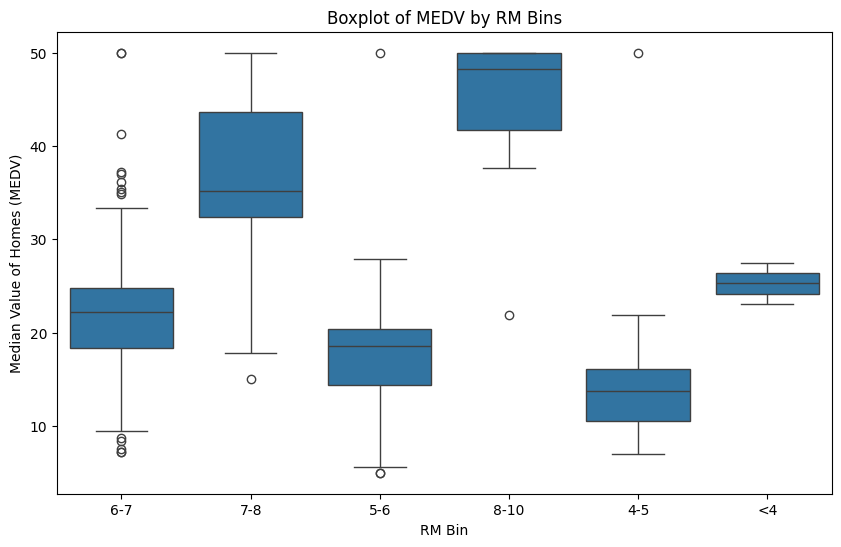

In [ ]:

# Create a boxplot for MEDV by RM bins
plt.figure(figsize=(10, 6))
sns.boxplot(x='RM_bin', y='MEDV', data=df_pd)
plt.title('Boxplot of MEDV by RM Bins')
plt.xlabel('RM Bin')
plt.ylabel('Median Value of Homes (MEDV)')
plt.show()

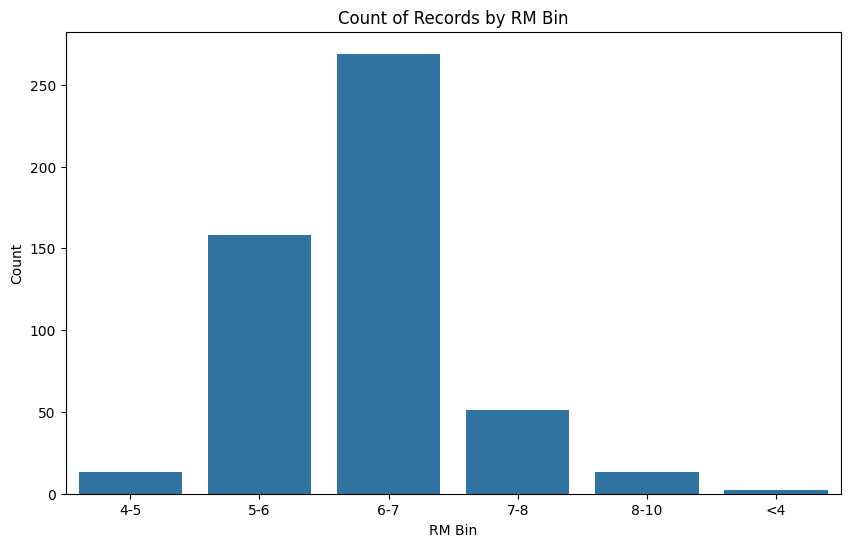

In [ ]:
# Create a bar plot for the count of records in each RM bin
rm_bin_counts = df_pd['RM_bin'].value_counts().sort_index()
plt.figure(figsize=(10, 6))
sns.barplot(x=rm_bin_counts.index, y=rm_bin_counts.values)
plt.title('Count of Records by RM Bin')
plt.xlabel('RM Bin')
plt.ylabel('Count')
plt.show()